# Part B Recurrent Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [132]:
import tensorflow as tf
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from wordcloud import WordCloud

## Checking GPU

In [80]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Setting Random Seed

In [81]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

## Problem Statement
Our Goal of this project is to build a next-word predictor, given a sequence of words. Our model should also produce different sequences of words given the same input.
## Goals of this project
### Generalization
> We need a model that generalizes well to different input sequences beyond the training data.
### Accuracy of Predictions
> We need to make our model accurately predicts the next word in a given sequence, especially for the provided seed_texts. Idealy around 85% of our choosen evaluation metrics
### Variabilty in Output
> We need to create a model that is capable of producing different and diverse sequences for the same input.

# Importing Dataset

In [82]:
df = pd.read_csv('./datasets/train (1).csv')
print(df)

                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]


In [83]:
print(f'There are {len(df)} quotes in this dataset.')
df.head(5)

There are 1000 quotes in this dataset.


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."


# EDA
What insights can we get from our data?
- What is the frequency distribution of words in our dataset?
- What is the distribution of lengths of quotes from our dataset? Are there any outliers?

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Quotes  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


### Checking for any Missing or Null Values

In [85]:
df.isnull().sum()

Quotes    0
dtype: int64

### Checking for duplicates

In [86]:
duplicates = df.duplicated()
print(f'Number of duplicate rows = {duplicates.sum()}')

Number of duplicate rows = 110


In [87]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
duplicate_rows = df.duplicated()
print(f'Number of duplicate rows = {duplicate_rows.sum()}')
df

Number of duplicate rows = 0


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
885,"With an open heart, welcome the opportunities ..."
886,"This morning, let your laughter be the music t..."
887,"In the serenity of this morning, find the powe..."
888,"This morning, let your actions be a testament ..."


### Checking for Numerical values

In [88]:
is_numeric = df['Quotes'].apply(lambda x: str(x).isnumeric())
print(f'Number of numeric quotes = {is_numeric.sum()}')

Number of numeric quotes = 0


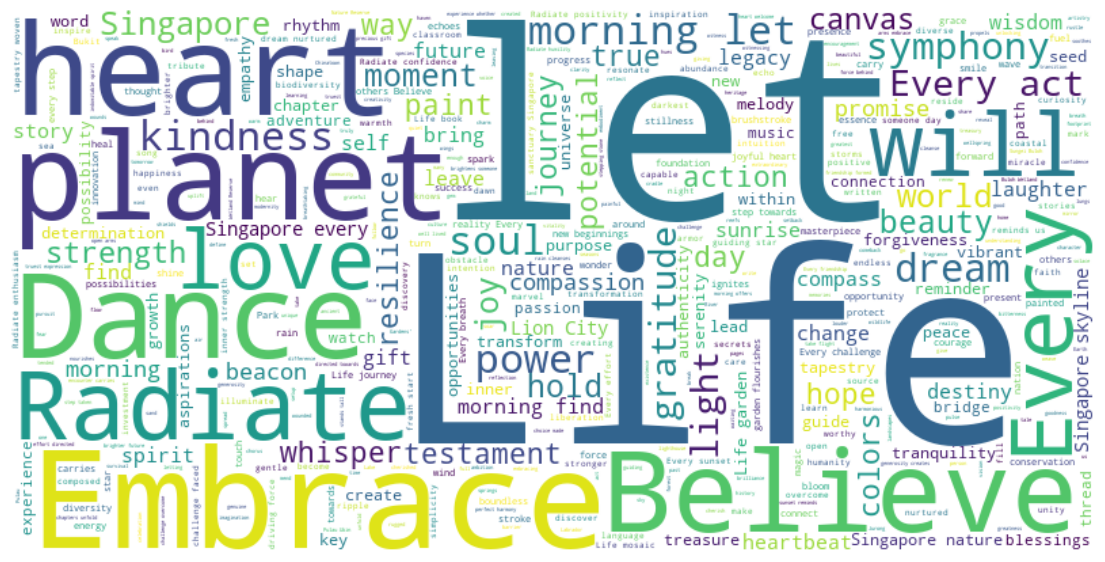

In [89]:
text = " ".join(quote for quote in df.Quotes)

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=5000).generate(text)

# Display the generated image
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observations:
- We can see that the words, "Let" , "Life" , "Embrace" and "heart" are the most common words found in our dataset. 
- We would expect the words, "the","and" as the most common words but we dont see them.This happens because wordcloud automatically removes common stopswords like "the" "and" "is"  to focus on meaningful words and avoid cluttering the visualization with frequently occurring but less informative words.

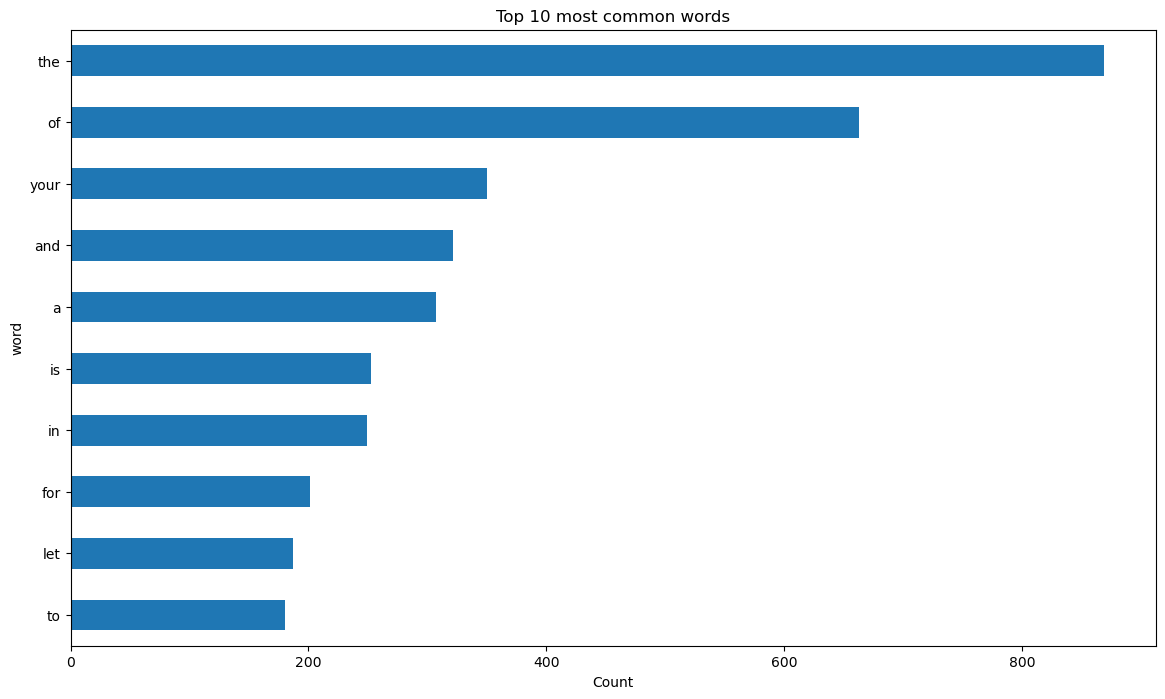

In [90]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Quotes'])
word_counts = tokenizer.word_counts
common_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

df_common_words.sort_values(by='count').plot(kind='barh', x='word', y='count', legend=False,figsize=(14,8))
plt.xlabel('Count')
plt.title('Top 10 most common words')
plt.show()

Observations:
- The most frequent words are now the common stopwords like "the", "of", "your" and "and". 
- Without wordcloud automatically removing them we can see that all of the top 10 most common words found in our dataset are stop words.

In [91]:
num_unique_words = len(tokenizer.word_index) + 1 # +1 for padding
print(f'Number of unique words: {num_unique_words}')

Number of unique words: 1199


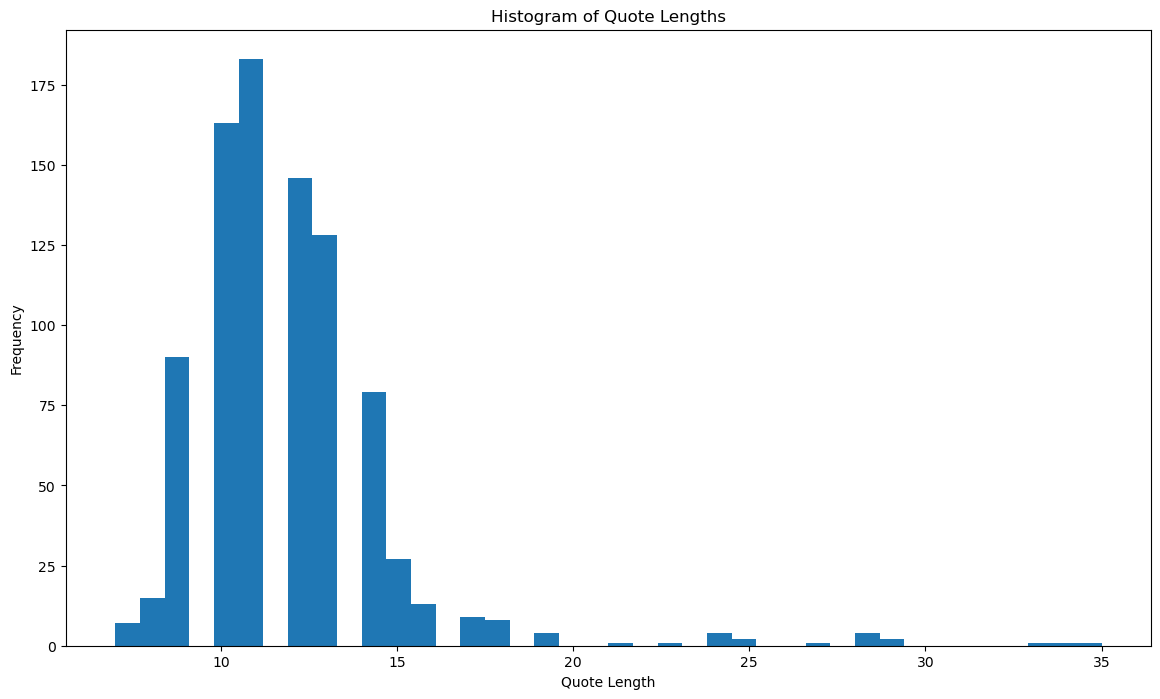

In [92]:
tokenizer = Tokenizer()
# Fit the tokenizer on the quotes
tokenizer.fit_on_texts(df['Quotes'])
# Get the sequences of tokens for each quote
sequences = tokenizer.texts_to_sequences(df['Quotes'])
# Get the word length of each quote
df['Quote Word Length'] = [len(seq) for seq in sequences]

# Create a histogram of quote lengths
df['Quote Word Length'].plot(kind='hist', bins=40,figsize=(14,8))
plt.xlabel('Quote Length')
plt.title('Histogram of Quote Lengths')
plt.show()

Observations:
- We can see that most quotes are around 10-12 words long, with a few outliers at around 35 words long
- We might need to pad sequences to a length slightly beyond our typical quote length to capture the majority of our quotes effectively.

### Phrase Analysis

In [93]:
for i in range(2,5):
    vectorizer = CountVectorizer(ngram_range=(i, i))
    X = vectorizer.fit_transform(df['Quotes'])
    df_ngrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    bigram_counts = df_ngrams.sum()
    common_ngrams = bigram_counts.nlargest(10)
    print(f'\nCommon {i}-grams:')
    print(common_ngrams)


Common 2-grams:
be the          126
let your        124
in the          101
this morning     97
of your          96
for it           93
our planet       92
embrace the      89
believe in       84
in yourself      83
dtype: int64

Common 3-grams:
believe in yourself    83
for it is              65
in yourself and        63
it is the              61
and you will           53
yourself and you       52
dance through the      51
this morning let       51
and let it             46
morning let your       41
dtype: int64

Common 4-grams:
believe in yourself and    63
for it is the              57
in yourself and you        52
yourself and you will      52
this morning let your      41
and let it be              38
let it be the              37
embrace the power of       25
believe in yourself for    20
of this morning find       20
dtype: int64


Observations:
- We can see from analysing our phrases that the sentiment of our text data is leaning more towards a motivational and positve tone.
    - Recurring motifs such as self-belief and taking action
    - We can see that many n-grams convey positive and motivational themes, encouraging personal growth, confidence, and positive actions.

# Data Preprocessing
- out of vocabilary
- contractions
- Tokenise the data
- handle missing and irelevant data
- Perform text cleaning, including removing stop words, punctuation, and special characters.
- Convert text data into a numerical format suitable for RNNs. (using neural network)

## Finding any unusual words in the English Language

In [94]:
nltk.download('words')
nltk.download('punkt')
from nltk.corpus import words
words.readme().replace('\n', ' ')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'Wordlists  en: English, http://en.wikipedia.org/wiki/Words_(Unix) en-basic: 850 English words: C.K. Ogden in The ABC of Basic English (1932) '

In [95]:
from nltk import word_tokenize
text_tokenized = df['Quotes'].apply(word_tokenize)
english_vocab = set(w.lower() for w in words.words())

text_vocab = set(w.lower() for quote in text_tokenized for w in quote if w.isalpha() and not w.endswith(('s', 'ing', 'ed', 'er', 'ly','est')))

unusual = text_vocab.difference(english_vocab)

print(unusual)

{'macritchie', 'soundtrack', 'clarke', 'wetland', 'sentosa', 'changi', 'asia', 'timah', 'ubin', 'buloh', 'singapore', 'batok', 'hantu', 'semakau', 'brushstroke', 'hindhede', 'coney', 'tekong', 'pulau', 'chek', 'jurong', 'merlion', 'kranji', 'peranakan', 'jawa', 'bukit', 'sungei', 'biodiversity', 'skyline', 'punggol'}


Observations:
- We can see that most unusual words our code has found are words mostly used in Singapore's context, for example "punggol" where this is not an english word but in Malay.It suggests that, this text is unique in the context of Singapore where we have a mix of many different cultures and thus implement words from all types of langugaes apart from English in our daily speaking habits.

## Cleaning our Text
We will be cleaning our text from punctuation, 
removing any special characters that may not convey meaningful information and lastly convert all our text to lowercase to ensure uniformity

In [96]:
import string

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove special characters
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply text cleaning to the 'Quotes' column
df['Quotes'] = df['Quotes'].apply(clean_text)
df

,Quotes,Quote Word Length
0,embrace the beauty of every sunrise its a fres...,16
1,embrace challenges they are the stepping stone...,11
2,embrace the rhythm of life and let it dance th...,12
3,embrace kindness for it has the power to chang...,16
4,embrace the journey for it leads to the destin...,12
...,...,...
885,with an open heart welcome the opportunities a...,15
886,this morning let your laughter be the music th...,16
887,in the serenity of this morning find the power...,18
888,this morning let your actions be a testament t...,18


## Lemmitimizing our data
It involves reducing our words to their base or dictionary forms, known as lemmas. For example, the lemma of "dancing" is dance. We will be trying it out on our models to see whether it improves its performance

### How does it help?
There are many ways in theory for lemmitimizing our words that will help our model.
- It helps reduce our vocabulary size by grouping inflected forms together, thus reducing training times
- Lemmatization may help the RNN generalize more effectively as our model may learn patterns and relationships that are applicable across various forms of a word.

However, lemmitimizing our words can lead to loss in infomation,especially if our specific inflection of a word carries important context. For example "Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy" the lemma of "its" is "it". With "it" replacing "its", the sentence changes to not making much sense anymore.

We will test it on our model to see how our model performs when presented with lemmitimized input-output sequences as compared to without.

In [97]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Define a function that lemmatizes each word in a text
def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in words])

# Apply the function to your DataFrame
# Assuming 'text_column' is the name of the column containing the text
df['Lemmitized_Quotes'] = df['Quotes'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [98]:
df

,Quotes,Quote Word Length,Lemmitized_Quotes
0,embrace the beauty of every sunrise its a fres...,16,embrace the beauty of every sunrise it a fresh...
1,embrace challenges they are the stepping stone...,11,embrace challenge they are the stepping stone ...
2,embrace the rhythm of life and let it dance th...,12,embrace the rhythm of life and let it dance th...
3,embrace kindness for it has the power to chang...,16,embrace kindness for it ha the power to change...
4,embrace the journey for it leads to the destin...,12,embrace the journey for it lead to the destina...
...,...,...,...
885,with an open heart welcome the opportunities a...,15,with an open heart welcome the opportunity and...
886,this morning let your laughter be the music th...,16,this morning let your laughter be the music th...
887,in the serenity of this morning find the power...,18,in the serenity of this morning find the power...
888,this morning let your actions be a testament t...,18,this morning let your action be a testament to...


## Input-Output pairs

In [99]:
#convert our df into a list
quotes = df['Quotes'].tolist()
lemmatized_quotes = df['Lemmitized_Quotes'].tolist()
quotes[:5]

['embrace the beauty of every sunrise its a fresh chance to paint your world with joy',
 'embrace challenges they are the stepping stones to your greatest victories',
 'embrace the rhythm of life and let it dance through your soul',
 'embrace kindness for it has the power to change the world one heart at a time',
 'embrace the journey for it leads to the destination of your dreams']

In [100]:
#tokenize our quotes
tokenizer = Tokenizer()
tokenizer_lem = Tokenizer()
tokenizer.fit_on_texts(quotes)
tokenizer_lem.fit_on_texts(lemmatized_quotes)
print("Without Lemmitimzing:\n",tokenizer.word_index)
print("\n")
print("With Lemmitimzing:\n",tokenizer_lem.word_index)

Without Lemmitimzing:
 {'the': 1, 'of': 2, 'your': 3, 'and': 4, 'a': 5, 'is': 6, 'in': 7, 'for': 8, 'let': 9, 'to': 10, 'it': 11, 'be': 12, 'every': 13, 'our': 14, 'you': 15, 'that': 16, 'embrace': 17, 'lifes': 18, 'this': 19, 'are': 20, 'morning': 21, 'with': 22, 'radiate': 23, 'dance': 24, 'heart': 25, 'believe': 26, 'yourself': 27, 'through': 28, 'planets': 29, 'will': 30, 'life': 31, 'love': 32, 'they': 33, 'singapores': 34, 'kindness': 35, 'power': 36, 'from': 37, 'dreams': 38, 'we': 39, 'soul': 40, 'symphony': 41, 'act': 42, 'find': 43, 'gratitude': 44, 'singapore': 45, 'strength': 46, 'world': 47, 'light': 48, 'beauty': 49, 'journey': 50, 'nature': 51, 'joy': 52, 'planet': 53, 'canvas': 54, 'colors': 55, 'way': 56, 'whispers': 57, 'where': 58, 'potential': 59, 'hope': 60, 'testament': 61, 'resilience': 62, 'towards': 63, 'true': 64, 'new': 65, 'compassion': 66, 'hearts': 67, 'beacon': 68, 'actions': 69, 'future': 70, 'spirit': 71, 'step': 72, 'change': 73, 'wisdom': 74, 'moments

In [101]:
total_words = len(tokenizer.word_index) + 1 # Because index 0 is reserved for padding.
total_words_lemmatized = len(tokenizer_lem.word_index) + 1 # Because index 0 is reserved for padding.
print(f'Total words without lemmatizing: {total_words}\n')
print(f'Total words with lemmatizing: {total_words_lemmatized}\n')

Total words without lemmatizing: 1200

Total words with lemmatizing: 1069



In [102]:
for i in range(5):
    print(f'Quote {i+1}:')
    print(quotes[i])
    print(tokenizer.texts_to_sequences([quotes[i]])[0])

Quote 1:
embrace the beauty of every sunrise its a fresh chance to paint your world with joy
[17, 1, 49, 2, 13, 78, 118, 5, 164, 481, 10, 99, 3, 47, 22, 52]
Quote 2:
embrace challenges they are the stepping stones to your greatest victories
[17, 148, 33, 20, 1, 369, 482, 10, 3, 370, 681]
Quote 3:
embrace the rhythm of life and let it dance through your soul
[17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40]
Quote 4:
embrace kindness for it has the power to change the world one heart at a time
[17, 35, 8, 11, 149, 1, 36, 10, 73, 1, 47, 371, 25, 483, 5, 296]
Quote 5:
embrace the journey for it leads to the destination of your dreams
[17, 1, 50, 8, 11, 248, 10, 1, 682, 2, 3, 38]


In [103]:
input_sequences = []
input_sequences_lem = []
for line in quotes:
    # Convert our line into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    token_list_lem = tokenizer_lem.texts_to_sequences([line])[0]
    input_sequences.append(token_list)
    input_sequences_lem.append(token_list_lem)

print(f'Number of input sequences: {len(input_sequences)}')

Number of input sequences: 890


In [104]:
print(input_sequences)

[[17, 1, 49, 2, 13, 78, 118, 5, 164, 481, 10, 99, 3, 47, 22, 52], [17, 148, 33, 20, 1, 369, 482, 10, 3, 370, 681], [17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40], [17, 35, 8, 11, 149, 1, 36, 10, 73, 1, 47, 371, 25, 483, 5, 296], [17, 1, 50, 8, 11, 248, 10, 1, 682, 2, 3, 38], [17, 3, 484, 8, 11, 6, 1, 683, 2, 3, 40, 91, 1, 120], [17, 1, 212, 105, 8, 11, 6, 1, 485, 371, 16, 297, 684], [17, 3, 372, 8, 33, 82, 1, 165, 10, 298, 3, 64, 59], [17, 44, 4, 130, 213, 11, 486, 1, 131, 7, 3, 31], [17, 1, 132, 8, 11, 373, 1, 110, 2, 3, 70, 166], [17, 1, 57, 2, 3, 25, 33, 167, 1, 74, 2, 1, 120], [17, 79, 8, 11, 6, 1, 133, 2, 5, 150, 25], [17, 1, 36, 2, 106, 8, 11, 374, 15, 299, 37, 1, 487, 2, 1, 375], [17, 1, 685, 11, 686, 376, 187, 249, 488, 489], [17, 1, 490, 75, 8, 33, 687, 82, 1, 370, 688], [17, 32, 8, 11, 6, 1, 214, 2, 1, 40], [17, 73, 8, 11, 6, 1, 485, 689, 7, 18, 300, 690], [17, 1, 691, 8, 11, 92, 1, 76, 2, 65, 134], [17, 3, 38, 8, 33, 20, 1, 491, 2, 3, 93], [17, 1, 55, 2, 31, 215, 7, 1, 692, 2,

In [105]:
final_input_output_pair = []
final_input_output_pair_lem = []
for x in range(max([len(x) for x in input_sequences]) - 1): 
    # print(x)
    input_output_pairs = []
    for datapoint in input_sequences:
        for i in range(len(datapoint) - x -1): # Why -1?
            input_output_pairs.append(datapoint[i:i + x + 2])
    final_input_output_pair += input_output_pairs
        
    # print(f'Total number of input-output pairs is: {len(input_output_pairs)}')

for x in range(max([len(x) for x in input_sequences_lem]) - 1):
    input_output_pairs_lem = []
    for datapoint in input_sequences_lem:
        for i in range(len(datapoint) - x -1): # Why -1?
            input_output_pairs_lem.append(datapoint[i:i + x + 2])
    final_input_output_pair_lem += input_output_pairs_lem

print(f'The total number of input-output pairs without Lemmitimizing are: {len(final_input_output_pair)}\n')
print(f'The total number of input-output pairs with Lemmitimizing are: {len(final_input_output_pair_lem)}\n')

The total number of input-output pairs without Lemmitimizing are: 61838

The total number of input-output pairs with Lemmitimizing are: 50912



### Pad our Sequences

In [106]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len_lem = max([len(x) for x in input_sequences_lem])
final_input_output_pair = np.array(sequence.pad_sequences(final_input_output_pair, maxlen=max_sequence_len, padding='pre'))
final_input_output_pair_lem = np.array(sequence.pad_sequences(final_input_output_pair_lem, maxlen=max_sequence_len_lem, padding='pre'))
print(final_input_output_pair.shape)
print(final_input_output_pair_lem.shape)

(61838, 35)
(50912, 35)


## Train test split

In [107]:
X = final_input_output_pair[:,:-1]
y = final_input_output_pair[:,-1]
X_lem = final_input_output_pair_lem[:,:-1]
y_lem = final_input_output_pair_lem[:,-1]

print(X[:5])
print(y[:5])

print(X.shape)
print(y.shape)
print(X_lem.shape)
print(y_lem.shape)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 13]]
[ 1 49  2 13 78]
(61838, 34)
(61838,)
(50912, 34)
(50912,)


### One hot encode y

In [108]:
y = utils.to_categorical(y, num_classes=total_words)
y_lem = utils.to_categorical(y_lem, num_classes=total_words_lemmatized)
print(y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_train_lem.shape)
print(y_train.shape)
print(y_train_lem.shape)

print(X_test.shape)
print(X_test_lem.shape)
print(y_test.shape)
print(y_test_lem.shape)

(49470, 34)
(40729, 34)
(49470, 1200)
(40729, 1069)
(12368, 34)
(10183, 34)
(12368, 1200)
(10183, 1069)


We will be splitting our data into train and test sets as we want to get a numerical understanding of how would the model perform on unseen data. However our model's next word prediction can be incohirent even though the loss curve shows that the model is performing well, So we need human interpretation to assess our model together with other evaluation metrics like perplexity.

# Models
We will be trying out 3 types of models for our next text prediction project:
- Baseline RNN
- Long Short-Term Memory (LSTM)

The baseline RNN will be the model that we will be comparing the other model off on. As they are supposedly better than the baseline recurant neural network. As they solve the vanishing gradient problem that RNNs seem to have.

### What makes a RNN different?
<img src="./images/unrolled-rnn.png" style="width: 30%">

[[Source]](https://builtin.com/data-science/recurrent-neural-networks-and-lstm)

The main feature that sets RNNs apart from ANNs is the presence of __recurrent connections__, which create loops that feed into itself in the network. This allows infomation to be passed from one step of the sequence to the next, enabling the network to maintain context and capture dependencies through time.

They are also designed to handle sequences of different lengths as the recurrent connections enables them to maintain a hidden state that evolves as the sequence progresses.
### Main Challenges
As our RNN continues to unfold and more sequences are added to it, it faces a problem where the gradient from back propagation becomes either too large or too small. Thus our optimization algorithm takes either a huge or a very small step to get to a local minima. The gradients either explode or diminish exponentially with each additional time step. To solve this, we can use more advanced RNN architechture such as LSTMs and GRUs. or we can limit the magnitude of gradients during training to prevent them from becoming too large.

## What does the Embedding layer do?
We want similar words that mean the same thing have similar numbers assigned to them! In this way our RNN would not need more complexity and training as learning how to correctly process similar words with similar meanings. So that learning how to use 1 word will help learn how to use the other word at the same time. We can do this by creating a vector space where words with similar meanings are close together. The Embedding layer converts discrete words or tokens into continuous, dense vectors.

### Evaluation metrics
We will be using __perplexity__ and __human assesment__ to assess our models
#### Perplexity
It measures how well a probability distribution or a language model predicts a sample. In other words it measures how well the probability distribution predicted by a model aligns with the actual distribution of words in a dataset. A lower perplexity indicates a better alignment. The formula is as such:

$$ PP = \exp\left(\frac{1}{N} \sum_{i=1}^{N} -\log P(x_i)\right) $$

Where:
- $ PP $ is the perplexity.
- $ N $ is the total number of words in the sequence.
- $ P(x_i) $ is the predicted probability assigned by the model to the actual word $ x_i $.
- $ \log $ is the natural logarithm.
- $ \exp $ is the exponentiation function.

It provides a quantitative measure of how well the model is capturing the patterns and structure of the language in the training data. However, quantitative measurements are not always accurate in measuring the model's performance thus we will also assess it with the text it has predicted and see whether there is any inconsistencies in the text.

<!-- - need to combat overfitting
- maybe when the model is performing good on paper(loss graph), it gives out incohirent answers to us
- evaluation models on metrics such as perplexity and human assesment -->
<!-- - such as perplexity or BLEU score) and qualitative evaluation (human assessment).
- word embeding, we wont be using word2vec as it is a pretrained model -->

In [110]:
def predict_next_word(input_text,model,tokenizer,max_sequence_len):
    tokens = tokenizer.texts_to_sequences([input_text])[0] 
    tokens = sequence.pad_sequences([tokens], maxlen=max_sequence_len-1, padding='pre') 
                                                                               
    prediction = np.argmax(model.predict(tokens, verbose=0), axis=1) 
    prediction = tokenizer.sequences_to_texts([prediction])[0] 
                                                              
    return prediction

def plot_loss_curve(history):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
def calculate_perplexity(model, X_test, y_test):
    # Predict probabilities for each class
    predictions = model.predict(X_test)

    # Flatten the arrays
    predictions_flat = predictions.flatten()
    y_test_flat = y_test.flatten()

    # Calculate negative log likelihood
    nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])

    # Calculate and return perplexity
    perplexity = np.exp(np.mean(nll))
    return perplexity

def evaluate_save_model(model,model_name,save_dir='./models',save_models=False, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, total_words=total_words):
    # Create directory if it doesn't exist
    if save_models:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # Save the model
        model_path = os.path.join(save_dir, model_name + '.h5')
        #replace the model if it already exists
        if os.path.exists(model_path):
            os.remove(model_path)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)

        model_history = model.history.history
        if os.path.exists(os.path.join(save_dir, model_name +'_history'+'.json')):
            os.remove(os.path.join(save_dir, model_name + '_history'+'.json'))
        json.dump(model_history, open(os.path.join(save_dir, model_name +'_history'+ '.json'), 'w'))
        print('Saved trained model history at %s ' % os.path.join(save_dir, model_name +'_history'+ '.json'))
    else:
        model_history = model.history.history
    result = {}
    best_epoch = np.argmin(model_history['val_loss'])
    result["Model Name"] = model_name
    result['train_loss'] = model_history['loss'][best_epoch]
    result['val_loss'] = model_history['val_loss'][best_epoch]
    result['train_perplexity'] = calculate_perplexity(model,X_train,y_train)
    result['val_perplexity'] = calculate_perplexity(model,X_test,y_test)
    result_series = pd.Series(result, name=result["Model Name"])
    return result_series

## Baseline RNN

We will be making a simple RNN model, with an Embedding layer to convert our token into vectors. A RNN layer with 128 cells and with a dropout layer to reduce overfitting and ending off with a output dense layer to predict the word. This will serve as a base for the rest of our models to continue improving off on. We will be using a batch size of 128 as with batch size 64, the RNN takes too long to train and thus due to time considerations we will be using batch size 128.

In [111]:
from tensorflow.keras.layers import SimpleRNN
tf.keras.backend.clear_session()
baseline_RNN = Sequential()
baseline_RNN.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
baseline_RNN.add(SimpleRNN(128, return_sequences=False))
baseline_RNN.add(Dense(total_words, activation='softmax'))
baseline_RNN.add(Dropout(0.2))
baseline_RNN.compile(loss='categorical_crossentropy', optimizer='adam')
baseline_RNN.summary()

history_baselineRNN = baseline_RNN.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=128,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 10)            12000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 184,592
Trainable params: 184,592
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
387/387 [==============================] - 16s 33ms/step - loss: 7.3664 - val_loss: 4.8261
Epoch 2/100
387/387 [==============================] - 12s 31ms/step - loss: 6.

In [113]:
evaluate_save_model(baseline_RNN,'Baseline_RNN',save_models=True)

Saved trained model at ./models\Baseline_RNN.h5 
Saved trained model history at ./models\Baseline_RNN_history.json 
387/387 [==============================] - 2s 5ms/step


Model Name          Baseline_RNN
train_loss              3.842676
val_loss                1.182068
train_perplexity        2.068972
val_perplexity          3.326484
Name: Baseline_RNN, dtype: object

In [114]:
seed_texts = ['embrace each day',
 'radiate some',
 'believe that',
 "life's actual purpose is",
 'dance through each and every',
 'let your time and energy',
 'every person is',
 'our country Singapore is',
 'planet earth is',
 'morning and evening would make it']

In [139]:
for seed_text in seed_texts:
    new_text = seed_text + ' ' + predict_next_word(seed_text,baseline_RNN,tokenizer,max_sequence_len)
    for i in range(15):
        new_text = new_text + ' ' + predict_next_word(new_text,baseline_RNN,tokenizer,max_sequence_len)
    print(new_text)

embrace each day is a canvas for new beginnings reminding us of the preciousness of every day start and
radiate some joy and let it be the melody of your lifes song of love and compassion will
believe that reflects our true purpose and passion it is the music of your soul on the universe
life's actual purpose is the music that plays in our hearts deepest desires painted with love and care and our
dance through each and every day is a canvas for new beginnings and fresh opportunities to new beginnings and fresh opportunities
let your time and energy you to moments of joy and happiness far and wide change innovation desires way to a
every person is the cradle from which life springs forth new beginnings and fresh opportunities to grow and become
our country Singapore is its testament to love and forgive a reminder of the marvel of existence and the boundless
planet earth is a treasure trove the strength and possibilities that this morning offers the promise of a fresh
morning and evening

Observations:
- If we skim through the predicted text, it will look ok at first glance. However when we read each line individually, we find that the sentences either does not make sense or the sentences are a combination of 2 seperate sentences.
- This relates to our high val_perplexity as compared to train_perplexity. From the results we can see that our model is not learning well to generalise to unseen data this suggests that our model maybe overfitting or our model architechture maybe too simple for our model to learn complex features leading to difficulties in generalization.

## Baseline with Lemmitimization
We will be trying to train our model with the Lemmitimized dataset, and see how it affects our model

In [116]:
baseline_RNN_lem = Sequential()
baseline_RNN_lem.add(Embedding(total_words_lemmatized, 10, input_length=max_sequence_len_lem-1))
baseline_RNN_lem.add(SimpleRNN(128, return_sequences=False))
baseline_RNN_lem.add(Dense(total_words_lemmatized, activation='softmax'))
baseline_RNN_lem.add(Dropout(0.2))
baseline_RNN_lem.compile(loss='categorical_crossentropy', optimizer='adam')
baseline_RNN_lem.summary()

history_baselineRNN_lem = baseline_RNN_lem.fit(X_train_lem, y_train_lem, epochs=100, verbose=1, validation_data=(X_test_lem, y_test_lem),batch_size=128,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 10)            10690     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               17792     
                                                                 
 dense_1 (Dense)             (None, 1069)              137901    
                                                                 
 dropout_1 (Dropout)         (None, 1069)              0         
                                                                 
Total params: 166,383
Trainable params: 166,383
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
319/319 [==============================] - 11s 33ms/step - loss: 7.1742 - val_loss: 4.7242
Epoch 2/100
319/319 [==============================] - 10s 30ms/step - loss: 

In [117]:
evaluate_save_model(baseline_RNN_lem,'Baseline_RNN_lem',save_models=True,X_train=X_train_lem,y_train=y_train_lem,X_test=X_test_lem,y_test=y_test_lem,total_words=total_words_lemmatized)

Saved trained model at ./models\Baseline_RNN_lem.h5 
Saved trained model history at ./models\Baseline_RNN_lem_history.json 
319/319 [==============================] - 2s 5ms/step


Model Name          Baseline_RNN_lem
train_loss                  3.827445
val_loss                    1.312694
train_perplexity            2.226196
val_perplexity               3.85045
Name: Baseline_RNN_lem, dtype: object

In [140]:
for seed_text in seed_texts:
    new_text = seed_text + ' ' + predict_next_word(seed_text,baseline_RNN_lem,tokenizer_lem,max_sequence_len_lem)
    for i in range(15):
        new_text = new_text + ' ' + predict_next_word(new_text,baseline_RNN_lem,tokenizer_lem,max_sequence_len_lem)
    print(new_text)

embrace each day full of generosity creates a world of abundance and the gentle will follow the magic of
radiate some positivity for it is a beacon that the way for others to the destination of your
believe that life welllived life each new day full of love and compassion you leave behind is boundless
life's actual purpose is a step towards the tranquility the tranquility of the heart a serene state where joy and
dance through each and every day overcome any challenge shaping the masterpiece that your heart free from the weight of your
let your time and energy it can heal and mend and restore faith fill own song of your journey a tale
every person is a canvas for new day ahead towards your true potential to transform and let your spirit
our country Singapore is a victory on the path to your soul and joy that meaningful bring to life commitment
planet earth is the melody of a life welllived joy and light up our planet a testament to your
morning and evening would make it with of love an

Observations:
- We can see that as compared to no Lemmitization, the val perplexity does not exhibit a significant improvement. This suggests that lemmatization may not always guarantee better generalization to unseen data.
    - This may be because to serveral reasons:
        - The reduction in vocabulary size achieved through lemmatization might not always be beneficial. In some cases, preserving the diversity of words could aid the model in capturing nuanced relationships.
        - While lemmatization aims to normalize grammatical forms, it might inadvertently oversimplify the language, potentially causing the model to lose some contextual nuances.
- There is not much of a difference of meaning from the predicted text as compared to the lemmitimized text, it suggests that lemmatixzation has not drastically altered  context of our generated sequences.

## Baseline With Gradient Clipping
We will be implementing gradient clipping to somewhat combat the exploding gradient problem and see how it affects our model.

In [119]:
from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()

baseline_RNN_GC = Sequential()
baseline_RNN_GC.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
baseline_RNN_GC.add(SimpleRNN(128, return_sequences=False))
baseline_RNN_GC.add(Dense(total_words, activation='softmax'))
baseline_RNN_GC.add(Dropout(0.2))

optimizer = Adam(clipvalue=1)

baseline_RNN_GC.compile(loss='categorical_crossentropy', optimizer=optimizer)
baseline_RNN_GC.summary()

history_baselineRNN_GP = baseline_RNN_GC.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=128,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 10)            12000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 184,592
Trainable params: 184,592
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
387/387 [==============================] - 14s 33ms/step - loss: 7.3179 - val_loss: 4.7560
Epoch 2/100
387/387 [==============================] - 12s 32ms/step - loss: 6.

In [120]:
evaluate_save_model(baseline_RNN_GC,'Baseline_RNN_GP',save_models=True)

Saved trained model at ./models\Baseline_RNN_GP.h5 
Saved trained model history at ./models\Baseline_RNN_GP_history.json 
387/387 [==============================] - 2s 5ms/step


Model Name          Baseline_RNN_GP
train_loss                 3.849927
val_loss                   1.220548
train_perplexity           2.089874
val_perplexity             3.427774
Name: Baseline_RNN_GP, dtype: object

In [141]:
for seed_text in seed_texts:
    new_text = seed_text + ' ' + predict_next_word(seed_text,baseline_RNN_GC,tokenizer,max_sequence_len)
    for i in range(15):
        new_text = new_text + ' ' + predict_next_word(new_text,baseline_RNN_GC,tokenizer,max_sequence_len)
    print(new_text)

embrace each day this morning inhale the promise of a fresh start and new beginnings reminding us of the
radiate some hope and let it be the sunrise in your darkest nights change this morning light up
believe that brightens someones day leaving a trail of smiles and warmth reside within lifes lifes course to
life's actual purpose is a tribute to the power of the heart to heal and transform to connect and uplift
dance through each and every heart to heal and transform to connect and uplift to create a legacy of warmth and
let your time and energy it can transform lives and inspire change and contentment reside our planet holds the potential to
every person is more vibrant when painted with empathy brushstrokes of survival where life unfolds its drama healing and
our country Singapore is a leap of faith for a triumphant comeback a return more powerful and determined peace in
planet earth is your purpose and meaning vision extraordinary has the wind and flow of life and the gentle
morning

Observations:
- The validation perplexity is still higher than the training perplexity, but the gap seems to be reduced somewhat as compared to our model without any gradient clipping. 
- The coherency for sentences are good for the first few words , however sentences start to not make sense after its 6th-7th prediction.

## LSTM

### Introduction to LSTMs
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture designed to address the challenges of RNNs. The vanishing or exploding gradient problem. First introduced in a paper "Long short-term memory" in 1997 by researchers Josef "Sepp" Hochreiter and Jürgen Schmidhuber. As seen in the earlier baseline RNN model, we encounter with a quite a big problem of vanishing/ exploding gradients, with training times becoming exceptionally long to train.
### Architechture
<img src="./images/LSTM_architechture.png" style="width: 40%">

[[Source]](https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c)




LSTMs are equipped with memory cells (as seen above) that can store and retrieve information over long periods. There are 2 seperate paths to make predictions, one path is for long term memories ($C_{t-1}$) and one is for short term memories ($H_{t-1}$).

We can see the __Memory line__ $C_{t-1}$ that runs through the top of the cell. That is the long term memory. Notice how there are no weights to modify the long term memory, this allows our long term memories to flow through our unrolled units without causing our gradient to explode or vanish.

We can see the __Hidden state__ $H_{t-1}$ thats runs through the bottom of the cell. This is the short term memory, they are connected to weights that can modify them.

The __Forget Gate__$F_t$ decides on what percentage should the long term memory be rembered. As the sigmoid activation function turns any number between 0 and 1. and we times that result with the current long term memory.

The __Candidate memory__ and the Input Gate $I_t$ work to together to decide on whether a new long term memory will be added to $C_{t-1}$. The Candidate memory combibnes the short-term memory and the input to create a potential long-term memory. And the Input Gate $I_t$ determines what percentage of the potential long term memory to add to the existing long-term memory.

The Final __output gate__ $o_t$ updates the short term memory, we start off with the new long term memory and use as the input into the tanh activation function. This represents a potential short term memory and now the LSTM has to decide on what percentage of the short term memory to remember we use a sigmoid activation function to determine the percentage. Then we get our new short term memory by multipling them together where we get $H_t$.
### Why LSTMs?
- LSTMs fix the problem of vanishing or exploding gradients encountered by basic RNNS.
- Specialized gates to control what information from the previous time step should be discarded, helping mitigate the vanishing gradient problem. and gating mechanisms to control the flow of gradients during backpropagation to preventing them from exploding.

### Why we wont be using Lemmitimization
- In our project, we want to preserve our word variations to capture meanings in our text.
- We can see that lemmatization oversimplifies word forms and leads to the loss of contextual information, when reading the predicted text.
- Eventhough we can see better results in our perplexity when using lemmatixation, we will be not using it due to project specifications.

## Base LSTM
We will be changing our base model's Simple RNN layer to a LSTM Layer, removing the dropout layer and changing the batch size to 64. and we will see our results

In [163]:
tf.keras.backend.clear_session()
baseline_LSTM = Sequential()
baseline_LSTM.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
baseline_LSTM.add(LSTM(128, return_sequences=False))
baseline_LSTM.add(Dense(total_words, activation='softmax'))
baseline_LSTM.add(Dropout(0.2))
baseline_LSTM.compile(loss='categorical_crossentropy', optimizer='adam')
baseline_LSTM.summary()
history_baselineLSTM = baseline_LSTM.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 392,048
Trainable params: 392,048
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 9s 9ms/step - loss: 7.0234 - val_loss: 4.3220
Epoch 2/100
773/773 [==============================] - 6s 7ms/step - loss: 6.2030

In [164]:
evaluate_save_model(baseline_LSTM,'Baseline_LSTM',save_models=True)

Saved trained model at ./models\Baseline_LSTM.h5 
Saved trained model history at ./models\Baseline_LSTM_history.json 
387/387 [==============================] - 1s 3ms/step


Model Name          Baseline_LSTM
train_loss               3.741789
val_loss                  1.03217
train_perplexity         1.960969
val_perplexity           2.850086
Name: Baseline_LSTM, dtype: object

In [165]:
for seed_text in seed_texts:
    new_text = seed_text + ' ' + predict_next_word(seed_text,baseline_LSTM,tokenizer,max_sequence_len)
    for i in range(15):
        new_text = new_text + ' ' + predict_next_word(new_text,baseline_LSTM,tokenizer,max_sequence_len)
    print(new_text)

embrace each day is a testament to your indomitable spirit and strength to overcome any obstacle that comes your
radiate some forgiveness for it sets your spirit free from bitterness and resentment a path towards healing and
believe that our planet encourages kindness for our planet holds a beacon that lights the way for others
life's actual purpose is an investment in your future success the soul of our planet encourages for it is the
dance through each and every breath let gratitude fill your lungs and heart this morning find the clarity and focus to
let your time and energy it radiates from your heart to the world like the rising sun let gratitude fill every
every person is the compass of your soul they carry your true essence of our planet encourages threads of
our country Singapore is a reminder of the earths lifegiving embrace the cycles of life on our planet encourages threads
planet earth is a canvas for new beginnings reminding us of the preciousness of every day is a gift
mor

Observations:
- Our base LSTM performs better than our RNNs models, with lower perplexity scores.
- We can see that LSTM solves the vanishing / exploding gradient problem with training times being x2 as fast, with almost the same parameters as our RNN models.
- Our predicted text has more coherence in it, with words forming more meaningful sequences compared to the RNN models. 
    - This improvement in language generation can be attributed to our LSTM's ability to selectively retain and forget information through its memory cell mechanism, allowing for better long-term dependencies in the generated sequences.

## LSTM with 2 layers
We will be  adding a new LSTM layer for greater model complexity and hopefully achieve better perplexity.

In [166]:
tf.keras.backend.clear_session()
LSTM_2l = Sequential()
LSTM_2l.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
LSTM_2l.add(LSTM(128, return_sequences=True))
LSTM_2l.add(LSTM(128, return_sequences=False))
LSTM_2l.add(Dense(total_words, activation='softmax'))
LSTM_2l.compile(loss='categorical_crossentropy', optimizer='adam')
LSTM_2l.summary()

history_LSTM = LSTM_2l.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 10)            12000     
                                                                 
 lstm (LSTM)                 (None, 34, 128)           71168     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
Total params: 369,552
Trainable params: 369,552
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 13s 10ms/step - loss: 5.2311 - val_loss: 4.7460
Epoch 2/100
773/773 [==============================] - 7s 10ms/step - loss: 4.4

In [167]:
evaluate_save_model(LSTM_2l,'LSTM_2l',save_models=True)

Saved trained model at ./models\LSTM_2l.h5 
Saved trained model history at ./models\LSTM_2l_history.json 
387/387 [==============================] - 2s 4ms/step


Model Name           LSTM_2l
train_loss          0.888594
val_loss            1.456286
train_perplexity    2.341444
val_perplexity          4.29
Name: LSTM_2l, dtype: object

In [168]:
for seed_text in seed_texts:
    new_text = seed_text + ' ' + predict_next_word(seed_text,LSTM_2l,tokenizer,max_sequence_len)
    for i in range(15):
        new_text = new_text + ' ' + predict_next_word(new_text,LSTM_2l,tokenizer,max_sequence_len)
    print(new_text)

embrace each day with a heart full of gratitude is a step towards a joyful heart welcome the opportunities
radiate some love for it is the key to unlocking your true potential to be the turning point
believe that transcends all barriers with grace and gratitude shape destinies to the seeds of your dreams they
life's actual purpose is the compass of endless discovery and passion and grace shape destinies well your body mind and
dance through each and every breath is a gift a reminder of the marvel the marvel of existence and the boundless
let your time and energy blooms like a garden in full bloom of your empathy of your understanding for within every
every person is a gift a reminder of the marvel the marvel of existence and the boundless possibilities it
our country Singapore is the compass of endless exploration and passion and grace shape destinies well your body mind and
planet earth is a step towards witnessing miracles the extraordinary moments that defy logic and touch the soul 

Observations:
- We can see that with greater model complexity, our LSTM model performs worse than our base LSTM model. With the perplexity being higher
- The sentences are less conherant and lack the smooth flow we observed in the predictions of the base LSTM model.

## LSTM with double the amount of neurons

In [169]:
tf.keras.backend.clear_session()
LSTM_2xNeurons = Sequential()
LSTM_2xNeurons.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
LSTM_2xNeurons.add(LSTM(256, return_sequences=False))
LSTM_2xNeurons.add(Dense(total_words, activation='softmax'))
LSTM_2xNeurons.add(Dropout(0.2))
LSTM_2xNeurons.compile(loss='categorical_crossentropy', optimizer='adam')
LSTM_2xNeurons.summary()
history_2xNeuronsLSTM = LSTM_2xNeurons.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 1200)              308400    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 793,968
Trainable params: 793,968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 7s 8ms/step - loss: 6.8446 - val_loss: 3.9015
Epoch 2/100
773/773 [==============================] - 5s 7ms/step - loss: 5.8026

In [170]:
evaluate_save_model(LSTM_2xNeurons,'LSTM_2xNeurons',save_models=True)

Saved trained model at ./models\LSTM_2xNeurons.h5 
Saved trained model history at ./models\LSTM_2xNeurons_history.json 
387/387 [==============================] - 1s 2ms/step


Model Name          LSTM_2xNeurons
train_loss                3.755655
val_loss                  1.023296
train_perplexity          1.953057
val_perplexity            2.833167
Name: LSTM_2xNeurons, dtype: object

In [171]:
for seed_text in seed_texts:
    new_text = seed_text + ' ' + predict_next_word(seed_text,LSTM_2xNeurons,tokenizer,max_sequence_len)
    for i in range(15):
        new_text = new_text + ' ' + predict_next_word(new_text,LSTM_2xNeurons,tokenizer,max_sequence_len)
    print(new_text)

embrace each day with a heart full of gratitude and watch how it transforms your world transform around you
radiate some joy and let it be the armor that shields your heart lead the way to success
believe that cuts through doubt and wisdom that resonates with the world around you of lifes precious gifts
life's actual purpose is a liberation of the soul a release from the chains of bitterness and resentment a path
dance through each and every moment into a gift a reminder of the miracle of life and resilience a reminder that
let your time and energy that words cannot into blessings into a stronger wiser and more resilient version of yourself and
every person is a testament to your inner strength and resilience a reminder that you are capable of conquering
our country Singapore is a promise to cherish and protect our planet and most beautiful when we move with grace
planet earth is a life welllived life and the gentle goodbyes of this morning find the power of being
morning and evening w

Observations:
- We can see that we have simliar results as compared to our baseline LSTM
- The sentences are quite coherant and convey meaningful messages

# Model Improvement
- OOV tokens
- synmomns

# Final Model